In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Ensure project root is on path
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

from src.utils import load_config

cfg = load_config("../config.yaml")
output_folder = Path(cfg["output_folder"]).resolve()
print("Output folder:", output_folder)

Output folder: B:\College\Niyati\bank-default-risk-merton-model\outputs


In [2]:
# Load Merton / KMV results computed earlier
results_path = output_folder / "merton_kmv_results.csv"
dd_df = pd.read_csv(results_path)
print("Loaded rows:", len(dd_df))
dd_df.head()

Loaded rows: 10


,Ticker,E,Sigma_E,D_total,ST_debt,LT_debt,V,Sigma_V,d1,d2,Merton_PD,KMV_DP,KMV_DD,KMV_PD
0,SBIBANK,6.749811e+12,0.299478,4.619989e+13,2.625716e+13,3.988544e+13,5.047724e+13,0.040052,3.603957,3.563905,0.000183,4.619989e+13,2.115682,0.017186
1,BANKBARODA,1.142440e+12,0.395868,1.854015e+13,1.130196e+13,1.447639e+13,1.868976e+13,0.024310,2.605245,2.580936,0.004927,1.854015e+13,0.329285,0.370970
2,CANBK,7.798717e+11,0.399892,2.293394e+13,1.007261e+13,2.572265e+13,2.248594e+13,0.013948,2.535908,2.521961,0.005835,2.293394e+13,-1.428463,0.923421
3,HDFCBANK,4.604539e+12,0.246321,1.651468e+13,4.023322e+11,3.222470e+13,2.023544e+13,0.056050,4.634377,4.578328,0.000002,1.651468e+13,3.280528,0.000518
4,ICICIBANK,4.768774e+12,0.286065,1.176310e+13,6.187341e+12,1.115152e+13,1.590237e+13,0.085786,4.198595,4.112809,0.000020,1.176310e+13,3.034213,0.001206


## 1. Definition of Distance to Default (DD)

In the KMV-style implementation, we typically define:

- Short-term debt: $ST$\n
- Long-term debt: $LT$\n
- Default Point: $DP = ST + 0.5 \times LT$\n
- Asset value: $V$ (from solving the Merton system)\n
- Asset volatility: $\sigma_V$ (annualized)\n

A simple one-period Distance to Default is then given by:

$$DD = \frac{V - DP}{V \cdot \sigma_V}$$

This is the number of standard deviations that $V$ is above the default point $DP$ over horizon $T=1$ year.

- If $DD \approx 0$, the firm is right at the edge of default.\n
- If $DD \approx 1$, asset value is one $\sigma_V$ above the default point.\n
- Larger $DD$ values (e.g. 3 or more) indicate very low default risk under the model assumptions.

In [3]:
# Re-compute Default Point (DP) and Distance to Default (DD) from raw columns
# to cross-check the KMV_DD that was already stored.

required_cols = ["V", "Sigma_V", "ST_debt", "LT_debt"]
print("Columns available:", dd_df.columns.tolist())
missing = [c for c in required_cols if c not in dd_df.columns]
if missing:
    raise ValueError(f"Missing columns in merton_kmv_results.csv: {missing}")

dd_df["DP_recalc"] = dd_df["ST_debt"] + 0.5 * dd_df["LT_debt"]
dd_df["DD_recalc"] = (dd_df["V"] - dd_df["DP_recalc"]) / (dd_df["V"] * dd_df["Sigma_V"])

# Compare stored KMV_DP / KMV_DD with recomputed versions
dd_df[["Ticker", "KMV_DP", "KMV_DD", "DP_recalc", "DD_recalc"]]

Columns available: ['Ticker', 'E', 'Sigma_E', 'D_total', 'ST_debt', 'LT_debt', 'V', 'Sigma_V', 'd1', 'd2', 'Merton_PD', 'KMV_DP', 'KMV_DD', 'KMV_PD']


,Ticker,KMV_DP,KMV_DD,DP_recalc,DD_recalc
0,SBIBANK,4.619989e+13,2.115682,4.619989e+13,2.115682
1,BANKBARODA,1.854015e+13,0.329285,1.854015e+13,0.329285
2,CANBK,2.293394e+13,-1.428463,2.293394e+13,-1.428463
3,HDFCBANK,1.651468e+13,3.280528,1.651468e+13,3.280528
4,ICICIBANK,1.176310e+13,3.034213,1.176310e+13,3.034213
5,AXISBANK,9.286845e+12,2.645413,9.286845e+12,2.645413
6,KOTAKBANK,1.079711e+13,3.237255,1.079711e+13,3.237255
7,INDUSINDBK,4.371560e+12,1.243347,4.371560e+12,1.243347
8,BAJFINANCE,1.927424e+12,2.869154,1.927424e+12,2.869154
9,PNB,1.119953e+13,1.118253,1.119953e+13,1.118253


In [4]:
# Numerical differences between stored and recomputed DD
dd_df["DD_diff"] = dd_df["KMV_DD"] - dd_df["DD_recalc"]
dd_df["DD_diff"].describe()

count    1.000000e+01
mean    -1.343370e-15
std      1.544102e-15
min     -3.552714e-15
25%     -2.164935e-15
50%     -1.276756e-15
75%     -9.436896e-16
max      1.998401e-15
Name: DD_diff, dtype: float64

## 2. Ranking banks by Distance to Default

Here we sort banks from **riskiest** (lowest DD) to **safest** (highest DD).

In [5]:
# Build a compact summary table
summary_cols = ["Ticker", "KMV_DD", "KMV_PD", "Merton_PD"]
summary = dd_df[summary_cols].copy()
summary = summary.sort_values("KMV_DD")
summary.reset_index(drop=True, inplace=True)
summary

,Ticker,KMV_DD,KMV_PD,Merton_PD
0,CANBK,-1.428463,0.923421,5.835139e-03
1,BANKBARODA,0.329285,0.370970,4.926649e-03
2,PNB,1.118253,0.131729,4.261841e-03
3,INDUSINDBK,1.243347,0.106870,7.659086e-03
4,SBIBANK,2.115682,0.017186,1.826893e-04
5,AXISBANK,2.645413,0.004080,1.673799e-04
6,BAJFINANCE,2.869154,0.002058,6.143469e-08
7,ICICIBANK,3.034213,0.001206,1.954366e-05
8,KOTAKBANK,3.237255,0.000603,5.539746e-06
9,HDFCBANK,3.280528,0.000518,2.343542e-06


In [6]:
# Basic summary statistics for DD and PD
stats = summary[["KMV_DD", "KMV_PD", "Merton_PD"]].describe()
stats

,KMV_DD,KMV_PD,Merton_PD
count,10.000000,10.000000,1.000000e+01
mean,1.844467,0.155864,2.306027e-03
std,1.530405,0.293727,3.019010e-03
min,-1.428463,0.000518,6.143469e-08
25%,1.149527,0.001419,9.040724e-06
50%,2.380548,0.010633,1.750346e-04
75%,2.992948,0.125515,4.760447e-03
max,3.280528,0.923421,7.659086e-03


### Interpretation of DD in this sample

- The **minimum DD** corresponds to the riskiest bank according to the KMV framework.\n
- The **median DD** gives a sense of the typical distance to default in the portfolio.\n
- The **maximum DD** corresponds to the safest bank.\n

In practice, model users sometimes map DD buckets to rating-like categories (e.g., DD < 1 as very risky, 1–2 as moderate, >3 as very safe), but these thresholds depend on calibration and should be treated as *heuristics* rather than hard rules.

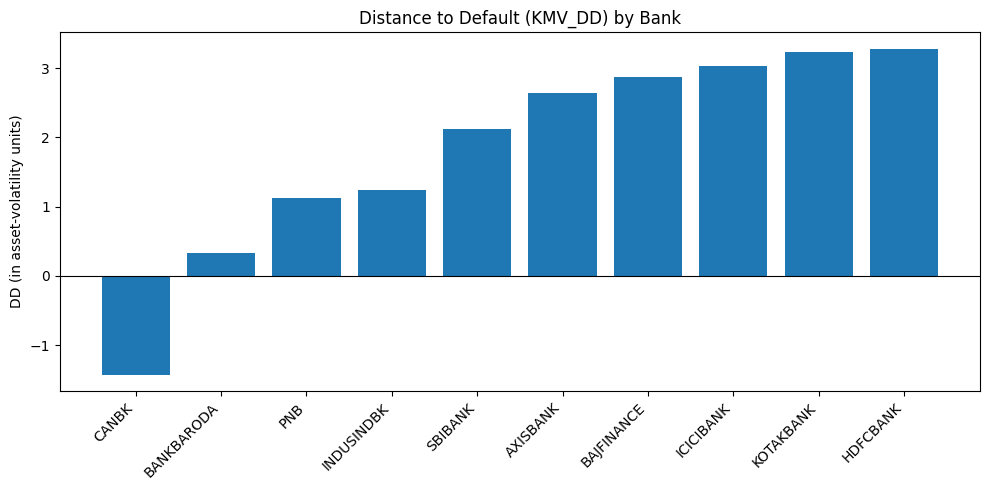

In [7]:
# Bar plot of Distance to Default (KMV_DD) by bank
plt.figure(figsize=(10, 5))
plt.bar(summary["Ticker"], summary["KMV_DD"], color='tab:blue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Distance to Default (KMV_DD) by Bank")
plt.ylabel("DD (in asset-volatility units)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

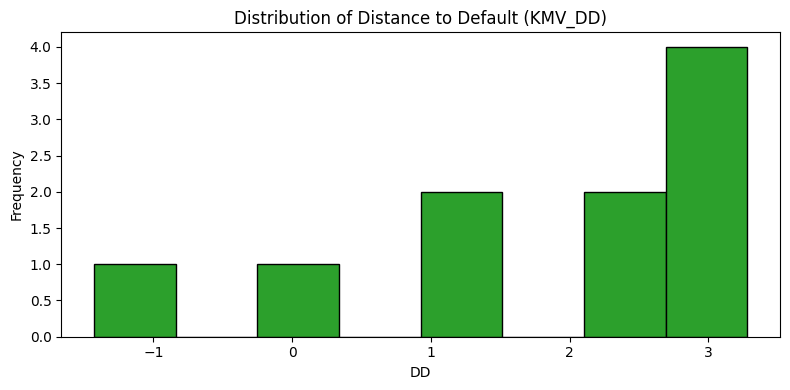

In [8]:
# Histogram of DD to see overall distribution
plt.figure(figsize=(8, 4))
plt.hist(dd_df["KMV_DD"], bins=8, color='tab:green', edgecolor='black')
plt.title("Distribution of Distance to Default (KMV_DD)")
plt.xlabel("DD")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

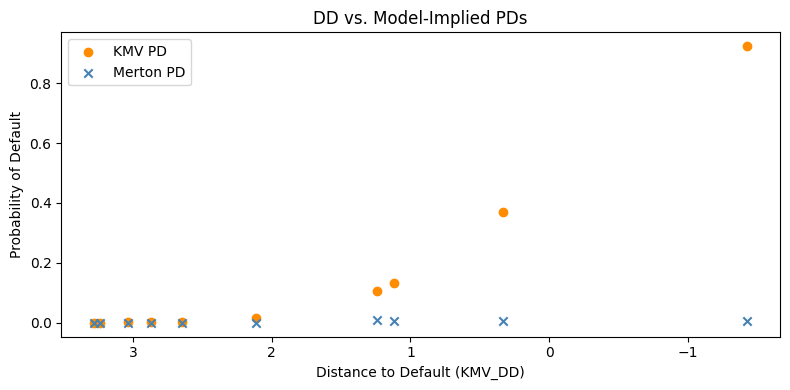

In [9]:
# Relationship between DD and model-implied PDs
plt.figure(figsize=(8, 4))
plt.scatter(dd_df["KMV_DD"], dd_df["KMV_PD"], color='darkorange', label='KMV PD')
plt.scatter(dd_df["KMV_DD"], dd_df["Merton_PD"], color='steelblue', label='Merton PD', marker='x')
plt.gca().invert_xaxis()  # lower DD (riskier) on the right visually
plt.xlabel("Distance to Default (KMV_DD)")
plt.ylabel("Probability of Default")
plt.title("DD vs. Model-Implied PDs")
plt.legend()
plt.tight_layout()
plt.show()

## 3. How DD relates to leverage and volatility

From the formula\n
$$DD = \frac{V - DP}{V \cdot \sigma_V},$$\n
you can see that:

- Higher **leverage** (larger $DP$ relative to $V$) pushes DD down.\n
- Higher **asset volatility** $\sigma_V$ also pushes DD down, because uncertainty makes default more likely.\n
- For a fixed $DP$ and $\sigma_V$, increasing $V$ increases DD.

In [10]:
# Construct simple leverage and volatility measures
dd_df["Leverage"] = dd_df["D_total"] / dd_df["V"]
dd_df["Sigma_V"] = dd_df["Sigma_V"]  # already there, just for clarity
dd_df[["Ticker", "Leverage", "Sigma_V", "KMV_DD"]]

,Ticker,Leverage,Sigma_V,KMV_DD
0,SBIBANK,0.915262,0.040052,2.115682
1,BANKBARODA,0.991995,0.024310,0.329285
2,CANBK,1.019924,0.013948,-1.428463
3,HDFCBANK,0.816127,0.056050,3.280528
4,ICICIBANK,0.739707,0.085786,3.034213
5,AXISBANK,0.761117,0.090301,2.645413
6,KOTAKBANK,0.742999,0.079389,3.237255
7,INDUSINDBK,0.941405,0.047127,1.243347
8,BAJFINANCE,0.262455,0.257060,2.869154
9,PNB,0.959191,0.036493,1.118253


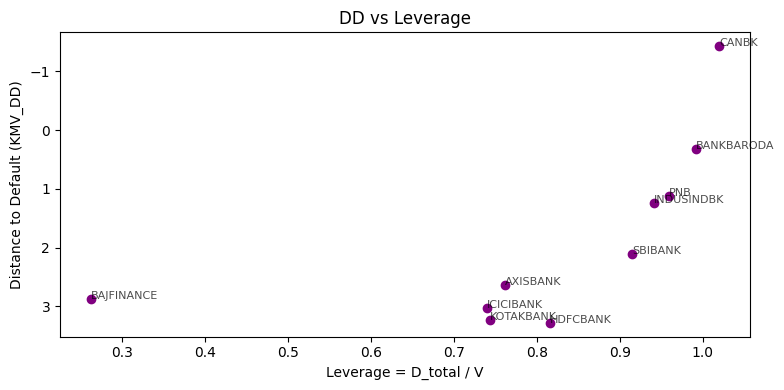

In [11]:
# Scatter: DD vs leverage
plt.figure(figsize=(8, 4))
plt.scatter(dd_df["Leverage"], dd_df["KMV_DD"], color='purple')
for _, row in dd_df.iterrows():
    plt.annotate(row["Ticker"], (row["Leverage"], row["KMV_DD"]), fontsize=8, alpha=0.7)
plt.xlabel("Leverage = D_total / V")
plt.ylabel("Distance to Default (KMV_DD)")
plt.title("DD vs Leverage")
plt.gca().invert_yaxis()  # higher leverage usually means lower DD
plt.tight_layout()
plt.show()

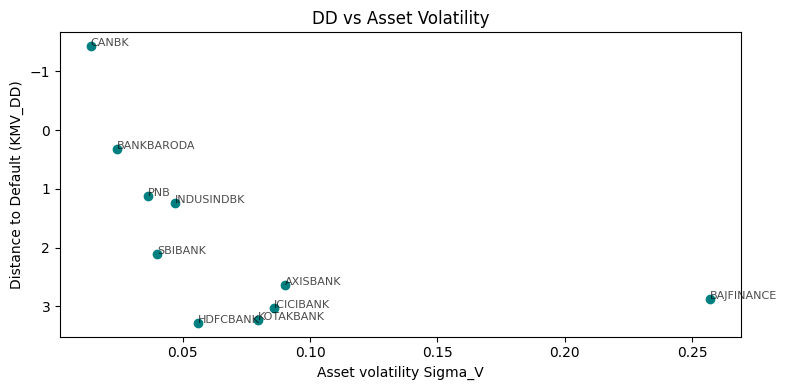

In [12]:
# Scatter: DD vs asset volatility
plt.figure(figsize=(8, 4))
plt.scatter(dd_df["Sigma_V"], dd_df["KMV_DD"], color='teal')
for _, row in dd_df.iterrows():
    plt.annotate(row["Ticker"], (row["Sigma_V"], row["KMV_DD"]), fontsize=8, alpha=0.7)
plt.xlabel("Asset volatility Sigma_V")
plt.ylabel("Distance to Default (KMV_DD)")
plt.title("DD vs Asset Volatility")
plt.gca().invert_yaxis()  # higher volatility usually means lower DD
plt.tight_layout()
plt.show()